# What's this PyTorch business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch (or TensorFlow, if you choose to use that notebook).

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version 1.0**. In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in Variable objects to be used in autograd; however Variables have now been deprecated. In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.

## How will I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I, Preparation: we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. Part V, CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [2]:
torch.__version__, torch.cuda.is_available()

('1.0.1.post2', True)

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10(
    './cs231n/datasets', train = True, download = True, transform = transform
)
loader_train = DataLoader(
    cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))
)

cifar10_val = dset.CIFAR10(
    './cs231n/datasets', train = True, download = True, transform = transform
)
loader_val = DataLoader(
    cifar10_val, batch_size = 64, sampler = sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000))
)

cifar10_test = dset.CIFAR10(
    './cs231n/datasets', train = False, download = True, transform = transform
)
loader_test = DataLoader(cifar10_test, batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [6]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [7]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # first layer: conv-relu
    x = F.conv2d(input = x, weight = conv_w1, bias = conv_b1, padding = 2)
    x = F.relu(x)
    
    # second layer: conv-relu
    x = F.conv2d(input = x, weight = conv_w2, bias = conv_b2, padding = 1)
    x = F.relu(x)
    
    # third layer: affine
    x = flatten(x)
    scores = x.mm(fc_w) + fc_b.view(1, -1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [8]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [9]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device = device, dtype = dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype = dtype, requires_grad = True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.3881, -1.6804, -0.6897, -0.0233,  1.1672],
        [-0.4894,  1.6122,  0.6072,  0.5446,  0.7380],
        [ 1.5881, -1.0637, -1.2275,  0.6275, -0.0036]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [10]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device, dtype = dtype)  # move to device, e.g. GPU
            y = y.to(device = device, dtype = torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [11]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device = device, dtype = dtype)
        y = y.to(device = device, dtype = torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [12]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.0584
Checking accuracy on the val set
Got 183 / 1000 correct (18.30%)

Iteration 100, loss = 2.1024
Checking accuracy on the val set
Got 319 / 1000 correct (31.90%)

Iteration 200, loss = 2.0259
Checking accuracy on the val set
Got 350 / 1000 correct (35.00%)

Iteration 300, loss = 2.4054
Checking accuracy on the val set
Got 405 / 1000 correct (40.50%)

Iteration 400, loss = 1.6645
Checking accuracy on the val set
Got 387 / 1000 correct (38.70%)

Iteration 500, loss = 1.7003
Checking accuracy on the val set
Got 404 / 1000 correct (40.40%)

Iteration 600, loss = 2.2887
Checking accuracy on the val set
Got 412 / 1000 correct (41.20%)

Iteration 700, loss = 1.9040
Checking accuracy on the val set
Got 425 / 1000 correct (42.50%)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch.

In [13]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = None
conv_b1 = None
conv_w2 = None
conv_b2 = None
fc_w = None
fc_b = None

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# first layer
conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight(channel_1)
shape1 = 1 + (32 + 2 * 2 - 5)

# second layer
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight(channel_2)
shape2 = 1 + (shape1 + 2 * 1 - 3)

# third layer
fc_w = random_weight((channel_2 * shape2 * shape2, 10))
fc_b = zero_weight(10)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 2.9003
Checking accuracy on the val set
Got 105 / 1000 correct (10.50%)

Iteration 100, loss = 1.9109
Checking accuracy on the val set
Got 348 / 1000 correct (34.80%)

Iteration 200, loss = 1.7712
Checking accuracy on the val set
Got 389 / 1000 correct (38.90%)

Iteration 300, loss = 1.6543
Checking accuracy on the val set
Got 425 / 1000 correct (42.50%)

Iteration 400, loss = 1.6715
Checking accuracy on the val set
Got 438 / 1000 correct (43.80%)

Iteration 500, loss = 1.7459
Checking accuracy on the val set
Got 454 / 1000 correct (45.40%)

Iteration 600, loss = 1.5735
Checking accuracy on the val set
Got 445 / 1000 correct (44.50%)

Iteration 700, loss = 1.4488
Checking accuracy on the val set
Got 478 / 1000 correct (47.80%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [14]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [15]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # first layer: conv-relu (define and initialize)
        self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding = 2)
#         self.conv1.weight.data = random_weight(self.conv1.weight.data.size())
#         self.conv1.bias.data = zero_weight(self.conv1.bias.data.size())
        nn.init.kaiming_normal_(self.conv1.weight)
        
        # second layer: conv-relu (define and initialize)
        self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding = 1)
#         self.conv2.weight.data = random_weight(self.conv2.weight.data.size())
#         self.conv2.bias.data = zero_weight(self.conv2.bias.data.size())
        nn.init.kaiming_normal_(self.conv2.weight)
        # last layer: fully connected (define and initialize)
        self.fc = self.fc1 = nn.Linear(channel_2 * 32 * 32, num_classes)
#         self.fc.weight.data = random_weight(self.fc.weight.data.size())
#         self.fc.bias.data = zero_weight(self.fc.bias.data.size())
        nn.init.kaiming_normal_(self.fc.weight)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        scores = self.fc(flatten(x))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel = 3, channel_1 = 12, channel_2 = 8, num_classes = 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [16]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device, dtype = dtype)  # move to device, e.g. GPU
            y = y.to(device = device, dtype = torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [17]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device = device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device = device, dtype = dtype)  # move to device, e.g. GPU
            y = y.to(device = device, dtype = torch.long)
#             if t % print_every == 0: 
#                 print(x[0][0])

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
#             if t % print_every == 0:
#                 print('x y: ',x.shape, y.shape)
#                 for name, param in model.named_parameters():
#                     if param.requires_grad and 'weight' in name: print (name, param.data.shape, param.data[0][0])
#                     if param.requires_grad and 'weight' not in name: print (name, param.data.shape, param.data)
            
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)                    
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [18]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 2.7306
Checking accuracy on validation set
Got 177 / 1000 correct (17.70)

Iteration 100, loss = 2.0685
Checking accuracy on validation set
Got 348 / 1000 correct (34.80)

Iteration 200, loss = 1.7872
Checking accuracy on validation set
Got 337 / 1000 correct (33.70)

Iteration 300, loss = 1.9681
Checking accuracy on validation set
Got 418 / 1000 correct (41.80)

Iteration 400, loss = 1.9856
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)

Iteration 500, loss = 1.8152
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)

Iteration 600, loss = 1.9517
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Iteration 700, loss = 1.4824
Checking accuracy on validation set
Got 469 / 1000 correct (46.90)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [19]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################
#torch.manual_seed(0)
train_part34(model, optimizer)

Iteration 0, loss = 3.3166
Checking accuracy on validation set
Got 121 / 1000 correct (12.10)

Iteration 100, loss = 2.0922
Checking accuracy on validation set
Got 324 / 1000 correct (32.40)

Iteration 200, loss = 1.7909
Checking accuracy on validation set
Got 377 / 1000 correct (37.70)

Iteration 300, loss = 1.8749
Checking accuracy on validation set
Got 403 / 1000 correct (40.30)

Iteration 400, loss = 1.7491
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 500, loss = 1.6875
Checking accuracy on validation set
Got 426 / 1000 correct (42.60)

Iteration 600, loss = 1.4790
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)

Iteration 700, loss = 1.5499
Checking accuracy on validation set
Got 460 / 1000 correct (46.00)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [20]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3524
Checking accuracy on validation set
Got 146 / 1000 correct (14.60)

Iteration 100, loss = 1.6016
Checking accuracy on validation set
Got 389 / 1000 correct (38.90)

Iteration 200, loss = 1.4760
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)

Iteration 300, loss = 1.6311
Checking accuracy on validation set
Got 423 / 1000 correct (42.30)

Iteration 400, loss = 1.4796
Checking accuracy on validation set
Got 430 / 1000 correct (43.00)

Iteration 500, loss = 1.6087
Checking accuracy on validation set
Got 425 / 1000 correct (42.50)

Iteration 600, loss = 1.9677
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)

Iteration 700, loss = 1.5256
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)



### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [21]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# function to initialize weights / bias
def init_weights(layer):
    if type(layer) in [nn.Conv2d, nn.Linear]:
        torch.nn.init.xavier_uniform_(layer.weight) #TODO: Why kaiming imit doesn't work?
#         torch.nn.init.kaiming_normal(layer.weight) 
#         layer.weight.data = random_weight(layer.weight.data.size())
        layer.bias.data = zero_weight(layer.bias.data.size())
    
    
conv1 = nn.Conv2d(3, channel_1, 5, padding = 2)
conv2 = nn.Conv2d(channel_1, channel_2, 3, padding = 1)
fc = nn.Linear(channel_2 * 32 * 32, 10)
    
# sequential model
model = nn.Sequential(
    conv1, #nn.Conv2d(3, channel_1, 5, padding = 2),
    nn.ReLU(),
    conv2, #nn.Conv2d(channel_1, channel_2, 3, padding = 1),
    nn.ReLU(),
    Flatten(),
    fc
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################
torch.manual_seed(0)
train_part34(model, optimizer)

Iteration 0, loss = 2.3583
Checking accuracy on validation set
Got 106 / 1000 correct (10.60)

Iteration 100, loss = 1.5216
Checking accuracy on validation set
Got 465 / 1000 correct (46.50)

Iteration 200, loss = 1.4278
Checking accuracy on validation set
Got 479 / 1000 correct (47.90)

Iteration 300, loss = 1.4462
Checking accuracy on validation set
Got 503 / 1000 correct (50.30)

Iteration 400, loss = 1.2842
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)

Iteration 500, loss = 1.4638
Checking accuracy on validation set
Got 570 / 1000 correct (57.00)

Iteration 600, loss = 1.4801
Checking accuracy on validation set
Got 563 / 1000 correct (56.30)

Iteration 700, loss = 1.3273
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)



# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [96]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# function to initialize weights / bias
def init_weights(layer, algo = 'xavier'):
    """
    To initialize weights and bias
    
    Inputs:
    - layer
    - type of init (algo)
    
    Returns: Nothing but initialize weight for chosen layer
    """
    #TODO: Why kaiming init doesn't work?
    if type(layer) not in [nn.Conv2d, nn.Linear]: return
    
    layer.bias.data = zero_weight(layer.bias.data.size())
    if algo == 'xavier':
        torch.nn.init.xavier_uniform_(layer.weight)
    elif algo == 'kaiming':
        torch.nn.init.kaiming_normal(layer.weight) 
    else: # should be same to kaimimg
        layer.weight.data = random_weight(layer.weight.data.size())
        

# build **check_accuracy_my** function
def check_accuracy_my(loader, model, l2_reg = False, ratio = .5):
    """
    Validate accuracy and loss of pretrained Model (PyTorch Module API)
    If dataset is train accuracy on validation set, else on test set.
    (loader.dataset.train <- boolean)
    
    Inputs:
    - loader
    - model
    - display 
    
    Returns:
    - num_correct, num_samples
    - accuracy
    - loss
    """
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device = device, dtype = dtype)  # move to device, e.g. GPU
            y = y.to(device = device, dtype = torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            if l2_reg:
                s = 0
                for param in model.parameters():
                    s += torch.norm(param)
                loss += ratio * s
            losses.append(loss)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if num_samples > 1000: break
    
        acc = 100 * float(num_correct) / num_samples
        loss = sum(losses) / len(losses)
    return acc, loss

# build my **train_part function **
def train_my(model, optimizer, epochs = 1, display = False, l2_reg = False, ratio = .5):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns (for each step): 
    - train_loss, valid_loss
    - train_accuracy, valid_accuracy
    - weights
    """
    model = model.to(device = device)  # move the model parameters to CPU/GPU
    num_correct = 0
    num_samples = 0
    hist = {
        'train': {
            'accuracy': [],
            'loss': []
        },
        'validate' : {
            'accuracy': [],
            'loss': []
        },
        'weights': {}
    }
    best_model = None
    best_iter = None
    best_accuracy = 0
    for e in range(epochs):
        if display:
            print('-' * 16)
            print('--- Epoch {}{} ---'.format(' ' * (2 - len(str(e))), e))
            print('-' * 16)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device = device, dtype = dtype)  # move to device, e.g. GPU
            y = y.to(device = device, dtype = torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            if l2_reg:
                s = 0
                for param in model.parameters():
                    s += torch.norm(param)
                loss += ratio * s
            
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            # collecting history info
            if (t + 1) % 20 == 0:
                # training data
                tacc, tloss = check_accuracy_my(loader_train, model, l2_reg = l2_reg, ratio = ratio)
                hist['train']['accuracy'].append(tacc)
                hist['train']['loss'].append(tloss.cpu().numpy())
                # validating data
                vacc, vloss = check_accuracy_my(loader_val, model)
                hist['validate']['accuracy'].append(vacc)
                hist['validate']['loss'].append(vloss.cpu().numpy())
                if vacc > best_accuracy:
                    best_model = model
                    best_iter = (e, t)
                    best_accuracy = vacc
                
            
            # displaying info
            if (t + 1) % 100 == 0 and display:
                print('Iteration %d, loss = %.4f' % (t + 1, loss.item()))
                print('Loss: train = {}, validate = {}'.format(tloss, vloss))
                print('Accuracy: train = {}, validate = {}'.format(round(tacc, 2), vacc))
                print()
    print('-' * 16)
    final_txt = 'The best accuracy = {} for epoch number {} and iterations number {}'
    print(final_txt.format(best_accuracy, *best_iter))
    return hist


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
# train_part34(model, optimizer, epochs=10)

In [100]:
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_8cv_4mp_l2 = train_my(model, optimizer, epochs = 10, display = True, l2_reg = True, ratio = 0.05)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 10:43:13
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 5.4762
Loss: train = 5.5426249504089355, validate = 2.0087878704071045
Accuracy: train = 26.86, validate = 25.9

Iteration 200, loss = 5.1755
Loss: train = 5.248335838317871, validate = 1.747997760772705
Accuracy: train = 33.89, validate = 36.4

Iteration 300, loss = 4.9925
Loss: train = 4.912398815155029, validate = 1.608791470527649
Accuracy: train = 41.31, validate = 40.6

Iteration 400, loss = 4.6858
Loss: train = 4.731585502624512, validate = 1.5254350900650024
Accuracy: train = 43.07, validate = 44.2

Iteration 500, loss = 4.3334
Loss: train = 4.526693820953369, validate = 1.4897407293319702
Accuracy: train = 43.26, validate = 45.7

Iteration 600, loss = 4.4174
Loss: train = 4.370055198669434, validate = 1.511061668395996
Accuracy: train = 49.02, validate = 45.1

Iteration 700, loss = 4.2089
Loss: train = 4.1274895668029785, validate = 1.3463221788406372
Accuracy: train = 50.29, validate 

Iteration 300, loss = 1.9274
Loss: train = 1.9736762046813965, validate = 0.9944676160812378
Accuracy: train = 66.31, validate = 66.0

Iteration 400, loss = 2.1551
Loss: train = 1.9981012344360352, validate = 0.9583486914634705
Accuracy: train = 64.45, validate = 67.1

Iteration 500, loss = 1.8000
Loss: train = 1.9475477933883667, validate = 0.9316786527633667
Accuracy: train = 66.6, validate = 68.7

Iteration 600, loss = 2.0482
Loss: train = 1.9519414901733398, validate = 0.9819350838661194
Accuracy: train = 68.75, validate = 68.4

Iteration 700, loss = 1.9777
Loss: train = 1.9581395387649536, validate = 0.9658413529396057
Accuracy: train = 64.75, validate = 66.1

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 1.9772
Loss: train = 2.013140916824341, validate = 1.0057597160339355
Accuracy: train = 66.21, validate = 65.3

Iteration 200, loss = 1.8764
Loss: train = 1.9114573001861572, validate = 0.9915581941604614
Accuracy: train = 69.24, validate = 66.0

Iterat

### 1. Basic architecture ([conv-relu]x2 -> [affine]x1 -> [softmax])

In [23]:
from time import time
from datetime import datetime

In [24]:
# parameter tuning

for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
    print('Learning rate = {}'.format(lr))
    # sequential model
    model_base = nn.Sequential(
        nn.Conv2d(3, channel_1, 5, padding = 2),
        nn.ReLU(),
        nn.Conv2d(channel_1, channel_2, 3, padding = 1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(channel_2 * 32 * 32, 10)
    )
    # initialize weights
    model_base.apply(init_weights)
    # optimizer with Nesterov momentum
    optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
    hist = train_my(model_base, optimizer, epochs = 2, display = False)
    print()

Learning rate = 0.0001
----------------
The best accuracy = 43.7 for epoch number 1 and iterations number 739

Learning rate = 0.001
----------------
The best accuracy = 57.8 for epoch number 1 and iterations number 719

Learning rate = 0.01
----------------
The best accuracy = 63.2 for epoch number 1 and iterations number 379

Learning rate = 0.1
----------------
The best accuracy = 11.9 for epoch number 0 and iterations number 199



In [99]:
# parameter tuning 2

for lr in [3e-3, 5e-3, 7e-3, 1e-2, 12e-3, 15e-3]:
    print('Learning rate = {}'.format(lr))
    # sequential model
    model_base = nn.Sequential(
        nn.Conv2d(3, channel_1, 5, padding = 2),
        nn.ReLU(),
        nn.Conv2d(channel_1, channel_2, 3, padding = 1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(channel_2 * 32 * 32, 10)
    )
    # initialize weights
    model_base.apply(init_weights)
    # optimizer with Nesterov momentum
    optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
    hist = train_my(model_base, optimizer, epochs = 2, display = False)
    print()

Learning rate = 0.003
----------------
The best accuracy = 61.1 for epoch number 1 and iterations number 719

Learning rate = 0.005
----------------
The best accuracy = 61.7 for epoch number 1 and iterations number 499

Learning rate = 0.007
----------------
The best accuracy = 61.6 for epoch number 1 and iterations number 439

Learning rate = 0.01
----------------
The best accuracy = 62.1 for epoch number 1 and iterations number 719

Learning rate = 0.012
----------------
The best accuracy = 62.8 for epoch number 1 and iterations number 659

Learning rate = 0.015
----------------
The best accuracy = 58.8 for epoch number 1 and iterations number 659



In [26]:
learning_rate = 0.007
    
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding = 2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding = 1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist = train_my(model_base, optimizer, epochs = 10, display = True)

----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.6491
Loss: train = 1.5940665006637573, validate = 1.5924984216690063
Accuracy: train = 44.53, validate = 42.9

Iteration 200, loss = 1.4962
Loss: train = 1.3973193168640137, validate = 1.3868449926376343
Accuracy: train = 50.88, validate = 51.9

Iteration 300, loss = 1.3474
Loss: train = 1.3853710889816284, validate = 1.3319414854049683
Accuracy: train = 52.15, validate = 54.0

Iteration 400, loss = 1.2960
Loss: train = 1.2345056533813477, validate = 1.301759958267212
Accuracy: train = 55.08, validate = 53.8

Iteration 500, loss = 1.4012
Loss: train = 1.2182258367538452, validate = 1.3112096786499023
Accuracy: train = 56.64, validate = 53.1

Iteration 600, loss = 1.1932
Loss: train = 1.0909335613250732, validate = 1.213526964187622
Accuracy: train = 61.52, validate = 56.9

Iteration 700, loss = 0.9497
Loss: train = 1.1456661224365234, validate = 1.216156244277954
Accuracy: train = 60.84, validate = 56.3

-------

Iteration 300, loss = 0.2760
Loss: train = 0.25714534521102905, validate = 1.8244588375091553
Accuracy: train = 91.31, validate = 60.7

Iteration 400, loss = 0.3904
Loss: train = 0.3044840097427368, validate = 1.8642923831939697
Accuracy: train = 89.16, validate = 59.2

Iteration 500, loss = 0.5799
Loss: train = 0.24476546049118042, validate = 1.8582122325897217
Accuracy: train = 90.72, validate = 58.5

Iteration 600, loss = 0.4745
Loss: train = 0.3082312345504761, validate = 1.823733925819397
Accuracy: train = 88.57, validate = 57.2

Iteration 700, loss = 0.4060
Loss: train = 0.3200939893722534, validate = 1.7912209033966064
Accuracy: train = 89.84, validate = 59.0

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.3223
Loss: train = 0.2494775652885437, validate = 1.9554015398025513
Accuracy: train = 91.5, validate = 59.2

Iteration 200, loss = 0.2865
Loss: train = 0.2289695143699646, validate = 1.9229929447174072
Accuracy: train = 91.99, validate = 58.9

Iter

In [27]:
%%time
# parameter tuning (channel & high size) for 1 epochs

# input: 64x3x32x32
channel = [32, 64, 128]
h1, pad1 = 5, 2
h2, pad2 = 3, 1
learning_rate = 0.007
epochs = 1

for h1 in [1, 3, 5, 7]:
    t = time()
    pad1 = (h1 - 1) // 2
    print('{1}. h1 = {0} | pad1 = {1}'.format(h1, pad1))
    print('+' * 80)
    for j in range(9):
        channel1, channel2 = channel[j // 3], channel[j % 3]
        print('{}. channel1 = {} | channel2 = {}'.format(j + 1, channel1, channel2))
        # sequential model
        model_base = nn.Sequential(
            nn.Conv2d(3, channel1, h1, padding = pad1),
            nn.ReLU(),
            nn.Conv2d(channel1, channel2, h2, padding = pad2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(channel2 * 32 * 32, 10)
        )
        # initialize weights
        model_base.apply(init_weights)
        # optimizer with Nesterov momentum
        optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
        hist = train_my(model_base, optimizer, epochs = epochs, display = False)
        print()
    print('+' * 80)
    print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))
    print()

0. h1 = 1 | pad1 = 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1. channel1 = 32 | channel2 = 32
----------------
The best accuracy = 55.4 for epoch number 0 and iterations number 739

2. channel1 = 32 | channel2 = 64
----------------
The best accuracy = 57.8 for epoch number 0 and iterations number 719

3. channel1 = 32 | channel2 = 128
----------------
The best accuracy = 57.7 for epoch number 0 and iterations number 579

4. channel1 = 64 | channel2 = 32
----------------
The best accuracy = 54.5 for epoch number 0 and iterations number 679

5. channel1 = 64 | channel2 = 64
----------------
The best accuracy = 55.8 for epoch number 0 and iterations number 759

6. channel1 = 64 | channel2 = 128
----------------
The best accuracy = 58.0 for epoch number 0 and iterations number 639

7. channel1 = 128 | channel2 = 32
----------------
The best accuracy = 55.1 for epoch number 0 and iterations number 659

8. channel1 = 128 | channel2 = 64
--------------

In [28]:
# parameter tuning (channel & high size) for 2 epochs

# input: 64x3x32x32
channel = [32, 64, 128]
h1, pad1 = 5, 2
h2, pad2 = 3, 1
learning_rate = 0.007
epochs = 2

for h1 in [1, 3, 5, 7]:
    t = time()
    pad1 = (h1 - 1) // 2
    print('{1}. h1 = {0} | pad1 = {1}'.format(h1, pad1))
    print('+' * 80)
    for j in range(9):
        channel1, channel2 = channel[j // 3], channel[j % 3]
        print('{}. channel1 = {} | channel2 = {}'.format(j + 1, channel1, channel2))
        # sequential model
        model_base = nn.Sequential(
            nn.Conv2d(3, channel1, h1, padding = pad1),
            nn.ReLU(),
            nn.Conv2d(channel1, channel2, h2, padding = pad2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(channel2 * 32 * 32, 10)
        )
        # initialize weights
        model_base.apply(init_weights)
        # optimizer with Nesterov momentum
        optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
        hist = train_my(model_base, optimizer, epochs = epochs, display = False)
        print()
    print('+' * 80)
    print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))
    print()

0. h1 = 1 | pad1 = 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1. channel1 = 32 | channel2 = 32
----------------
The best accuracy = 57.8 for epoch number 1 and iterations number 359

2. channel1 = 32 | channel2 = 64
----------------
The best accuracy = 59.2 for epoch number 1 and iterations number 359

3. channel1 = 32 | channel2 = 128
----------------
The best accuracy = 62.3 for epoch number 1 and iterations number 759

4. channel1 = 64 | channel2 = 32
----------------
The best accuracy = 57.8 for epoch number 1 and iterations number 579

5. channel1 = 64 | channel2 = 64
----------------
The best accuracy = 59.1 for epoch number 1 and iterations number 719

6. channel1 = 64 | channel2 = 128
----------------
The best accuracy = 61.4 for epoch number 1 and iterations number 699

7. channel1 = 128 | channel2 = 32
----------------
The best accuracy = 59.3 for epoch number 1 and iterations number 679

8. channel1 = 128 | channel2 = 64
--------------

In [28]:
# parameter tuning (channel & high size) for 3 epochs

# input: 64x3x32x32
channel = [32, 64, 128]
h1, pad1 = 5, 2
h2, pad2 = 3, 1
learning_rate = 0.007
epochs = 3

for h1 in [1, 3, 5, 7]:
    t = time()
    pad1 = (h1 - 1) // 2
    print('{1}. h1 = {0} | pad1 = {1}'.format(h1, pad1))
    print('+' * 80)
    for j in range(9):
        channel1, channel2 = channel[j // 3], channel[j % 3]
        print('{}. channel1 = {} | channel2 = {}'.format(j + 1, channel1, channel2))
        # sequential model
        model_base = nn.Sequential(
            nn.Conv2d(3, channel1, h1, padding = pad1),
            nn.ReLU(),
            nn.Conv2d(channel1, channel2, h2, padding = pad2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(channel2 * 32 * 32, 10)
        )
        # initialize weights
        model_base.apply(init_weights)
        # optimizer with Nesterov momentum
        optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
        hist = train_my(model_base, optimizer, epochs = epochs, display = False)
        print()
    print('+' * 80)
    print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))
    print()

0. h1 = 1 | pad1 = 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1. channel1 = 32 | channel2 = 32
----------------
The best accuracy = 62.3 for epoch number 2 and iterations number 739

2. channel1 = 32 | channel2 = 64
----------------
The best accuracy = 61.7 for epoch number 2 and iterations number 679

3. channel1 = 32 | channel2 = 128
----------------
The best accuracy = 62.5 for epoch number 2 and iterations number 759

4. channel1 = 64 | channel2 = 32
----------------
The best accuracy = 58.1 for epoch number 2 and iterations number 339

5. channel1 = 64 | channel2 = 64
----------------
The best accuracy = 60.8 for epoch number 2 and iterations number 499

6. channel1 = 64 | channel2 = 128
----------------
The best accuracy = 62.5 for epoch number 2 and iterations number 719

7. channel1 = 128 | channel2 = 32
----------------
The best accuracy = 60.5 for epoch number 2 and iterations number 39

8. channel1 = 128 | channel2 = 64
---------------

**Conclusion:** 1 epoch is enough to do tests

In [29]:
# parameter tuning (channels & high sizes) for 1 epochs

# input: 64x3x32x32
channel = [32, 64, 128]
learning_rate = 0.007
epochs = 1

for i in range(9):
    t = time()
    h1, h2 = (i // 3) * 2 + 1, (i % 3) * 2 + 1 # 1, 3, 5
    pad1, pad2 = (h1 - 1) // 2, (h2 - 1) // 2
    print('{}. h1 = {} | pad1 = {} | h2 = {} | pad2 = {}'.format(i, h1, pad1, h2, pad2))
    print('+' * 80)
    for j in range(9):
        channel1, channel2 = channel[j // 3], channel[j % 3]
        print('{}. channel1 = {} | channel2 = {}'.format(j + 1, channel1, channel2))
        # sequential model
        model_base = nn.Sequential(
            nn.Conv2d(3, channel1, h1, padding = pad1),
            nn.ReLU(),
            nn.Conv2d(channel1, channel2, h2, padding = pad2),
            nn.ReLU(),
            Flatten(),
            nn.Linear(channel2 * 32 * 32, 10)
        )
        # initialize weights
        model_base.apply(init_weights)
        # optimizer with Nesterov momentum
        optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
        hist = train_my(model_base, optimizer, epochs = epochs, display = False)
        print()
    print('+' * 80)
    print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))
    print()

0. h1 = 1 | pad1 = 0 | h2 = 1 | pad2 = 0
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1. channel1 = 32 | channel2 = 32
----------------
The best accuracy = 47.6 for epoch number 0 and iterations number 639

2. channel1 = 32 | channel2 = 64
----------------
The best accuracy = 49.7 for epoch number 0 and iterations number 719

3. channel1 = 32 | channel2 = 128
----------------
The best accuracy = 49.1 for epoch number 0 and iterations number 639

4. channel1 = 64 | channel2 = 32
----------------
The best accuracy = 48.3 for epoch number 0 and iterations number 539

5. channel1 = 64 | channel2 = 64
----------------
The best accuracy = 48.3 for epoch number 0 and iterations number 739

6. channel1 = 64 | channel2 = 128
----------------
The best accuracy = 50.3 for epoch number 0 and iterations number 759

7. channel1 = 128 | channel2 = 32
----------------
The best accuracy = 49.2 for epoch number 0 and iterations number 679

8. channel1 = 128 | channel2

----------------
The best accuracy = 59.5 for epoch number 0 and iterations number 759

4. channel1 = 64 | channel2 = 32
----------------
The best accuracy = 58.2 for epoch number 0 and iterations number 759

5. channel1 = 64 | channel2 = 64
----------------
The best accuracy = 59.4 for epoch number 0 and iterations number 599

6. channel1 = 64 | channel2 = 128
----------------
The best accuracy = 59.5 for epoch number 0 and iterations number 659

7. channel1 = 128 | channel2 = 32
----------------
The best accuracy = 56.8 for epoch number 0 and iterations number 639

8. channel1 = 128 | channel2 = 64
----------------
The best accuracy = 58.4 for epoch number 0 and iterations number 739

9. channel1 = 128 | channel2 = 128
----------------
The best accuracy = 58.4 for epoch number 0 and iterations number 759

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3 min. 29 sec.

7. h1 = 5 | pad1 = 2 | h2 = 3 | pad2 = 1
+++++++++++++++++++++++++++++++++++++++++++

**Conclusion:**
    
    h1 = h2 = 3
    filter1 = 32
    filter2 = 128

In [30]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
pad1, pad2 = (h1 - 1) //2, (h2 - 1) //2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel2 * 32 * 32, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_2cv = train_my(model_base, optimizer, epochs = 10, display = True)
print('Finished at {}'.format(str(datetime.now().time())[:8]))

Started at 12:57:53
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.4270
Loss: train = 1.4429123401641846, validate = 1.5181527137756348
Accuracy: train = 49.02, validate = 44.5

Iteration 200, loss = 1.1718
Loss: train = 1.3586666584014893, validate = 1.3776657581329346
Accuracy: train = 51.07, validate = 50.3

Iteration 300, loss = 1.1813
Loss: train = 1.139799952507019, validate = 1.2630722522735596
Accuracy: train = 60.64, validate = 54.8

Iteration 400, loss = 1.3233
Loss: train = 1.1438571214675903, validate = 1.2304917573928833
Accuracy: train = 61.52, validate = 56.1

Iteration 500, loss = 1.0376
Loss: train = 1.0053554773330688, validate = 1.1865495443344116
Accuracy: train = 64.45, validate = 58.6

Iteration 600, loss = 0.8823
Loss: train = 1.041122555732727, validate = 1.1365247964859009
Accuracy: train = 63.96, validate = 59.5

Iteration 700, loss = 1.1985
Loss: train = 0.9684606194496155, validate = 1.119594931602478
Accuracy: train = 65.72, vali

Iteration 300, loss = 0.0055
Loss: train = 0.009076600894331932, validate = 1.8046259880065918
Accuracy: train = 99.9, validate = 68.6

Iteration 400, loss = 0.0183
Loss: train = 0.00909971259534359, validate = 1.842092514038086
Accuracy: train = 99.8, validate = 68.2

Iteration 500, loss = 0.0121
Loss: train = 0.008836089633405209, validate = 1.8332260847091675
Accuracy: train = 99.9, validate = 68.6

Iteration 600, loss = 0.0154
Loss: train = 0.011598256416618824, validate = 1.8503260612487793
Accuracy: train = 99.8, validate = 67.6

Iteration 700, loss = 0.0111
Loss: train = 0.010358932428061962, validate = 1.8617841005325317
Accuracy: train = 99.8, validate = 68.4

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0026
Loss: train = 0.004727422725409269, validate = 1.8644927740097046
Accuracy: train = 100.0, validate = 67.6

Iteration 200, loss = 0.0076
Loss: train = 0.005112936720252037, validate = 1.8812029361724854
Accuracy: train = 100.0, validate = 68.

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%matplotlib inline

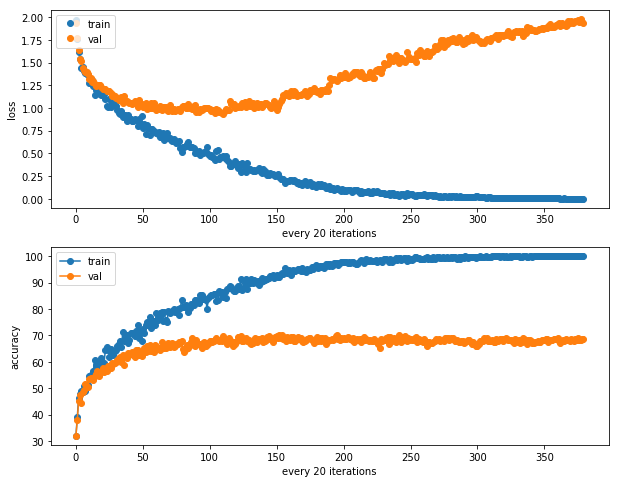

In [35]:
plt.subplot(2, 1, 1)
plt.plot(hist_2cv['train']['loss'], 'o')
plt.plot(hist_2cv['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_2cv['train']['accuracy'], '-o')
plt.plot(hist_2cv['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 1.1. Basic architecture ([conv-relu]x3 -> [affine]x1 -> [softmax])
Adding **1** more layer

In [36]:
# parameter tuning (channels & high sizes) for 1 epochs
# input: 64x3x32x32
channel1, h1, pad1 = 32, 3, 1
channel2, h2, pad2 = 128, 3, 1
learning_rate = 0.007

i = 0
tt = time()
for channel3 in [16, 32, 64, 128]:
    for h3 in [1, 3, 5 ,7]:
        t = time()
        i += 1
        pad3 = (h3 - 1) // 2
        print('{}. channel3 = {} | h3 = {} | pad3 = {}'.format(i, channel3, h3, pad3))

        # sequential model
        model_base = nn.Sequential(
            nn.Conv2d(3, channel1, h1, padding = pad1),
            nn.ReLU(),
            
            nn.Conv2d(channel1, channel2, h2, padding = pad2),
            nn.ReLU(),
            
            nn.Conv2d(channel2, channel3, h3, padding = pad3),
            nn.ReLU(),
            
            Flatten(),
            nn.Linear(channel3 * 32 * 32, 10)
        )
        # initialize weights
        model_base.apply(init_weights)
        # optimizer with Nesterov momentum
        optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
        # optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
        hist = train_my(model_base, optimizer, epochs = 1, display = False)
        print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))
        print()
print()
print('+' * 80)
print('Total time: {} min. {} sec.'.format(round(time() - tt) // 60, round(time() - tt) % 60))


1. channel3 = 16 | h3 = 1 | pad3 = 0
----------------
The best accuracy = 61.0 for epoch number 0 and iterations number 739
0 min. 28 sec.

2. channel3 = 16 | h3 = 3 | pad3 = 1
----------------
The best accuracy = 60.4 for epoch number 0 and iterations number 739
0 min. 34 sec.

3. channel3 = 16 | h3 = 5 | pad3 = 2
----------------
The best accuracy = 64.9 for epoch number 0 and iterations number 739
1 min. 5 sec.

4. channel3 = 16 | h3 = 7 | pad3 = 3
----------------
The best accuracy = 62.5 for epoch number 0 and iterations number 739
1 min. 9 sec.

5. channel3 = 32 | h3 = 1 | pad3 = 0
----------------
The best accuracy = 61.0 for epoch number 0 and iterations number 759
0 min. 29 sec.

6. channel3 = 32 | h3 = 3 | pad3 = 1
----------------
The best accuracy = 63.9 for epoch number 0 and iterations number 739
0 min. 36 sec.

7. channel3 = 32 | h3 = 5 | pad3 = 2
----------------
The best accuracy = 64.1 for epoch number 0 and iterations number 739
1 min. 10 sec.

8. channel3 = 32 | h3 

In [37]:
tt = time()
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
pad1, pad2, pad3 = (h1 - 1) //2, (h2 - 1) //2, (h3 - 1) //2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    
    Flatten(),
    nn.Linear(channel3 * 32 * 32, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_3cv = train_my(model_base, optimizer, epochs = 10, display = True)
print()
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('Total time: {} min. {} sec.'.format(round(time() - tt) // 60, round(time() - tt) % 60))


Started at 13:22:59
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.5919
Loss: train = 1.4743643999099731, validate = 1.4680657386779785
Accuracy: train = 48.54, validate = 46.6

Iteration 200, loss = 1.2851
Loss: train = 1.279634714126587, validate = 1.3736305236816406
Accuracy: train = 54.39, validate = 50.4

Iteration 300, loss = 1.2859
Loss: train = 1.2135682106018066, validate = 1.2697852849960327
Accuracy: train = 56.35, validate = 54.6

Iteration 400, loss = 1.1087
Loss: train = 1.1058355569839478, validate = 1.139879822731018
Accuracy: train = 61.52, validate = 60.5

Iteration 500, loss = 1.0729
Loss: train = 1.078282117843628, validate = 1.083053708076477
Accuracy: train = 62.3, validate = 62.8

Iteration 600, loss = 0.9715
Loss: train = 0.8913334012031555, validate = 1.0153359174728394
Accuracy: train = 69.14, validate = 63.3

Iteration 700, loss = 1.3313
Loss: train = 0.8936364650726318, validate = 1.0363352298736572
Accuracy: train = 70.02, valida

Iteration 300, loss = 0.0501
Loss: train = 0.022610653191804886, validate = 1.4487760066986084
Accuracy: train = 99.51, validate = 73.9

Iteration 400, loss = 0.0189
Loss: train = 0.06158215552568436, validate = 1.5557540655136108
Accuracy: train = 97.85, validate = 73.9

Iteration 500, loss = 0.0404
Loss: train = 0.02951805107295513, validate = 1.4583574533462524
Accuracy: train = 99.02, validate = 73.1

Iteration 600, loss = 0.0561
Loss: train = 0.035786863416433334, validate = 1.4567078351974487
Accuracy: train = 99.02, validate = 74.6

Iteration 700, loss = 0.0352
Loss: train = 0.030623437836766243, validate = 1.5319982767105103
Accuracy: train = 98.83, validate = 72.7

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0215
Loss: train = 0.024473972618579865, validate = 1.5646308660507202
Accuracy: train = 99.12, validate = 71.8

Iteration 200, loss = 0.0363
Loss: train = 0.019717585295438766, validate = 1.4496067762374878
Accuracy: train = 99.12, validate 

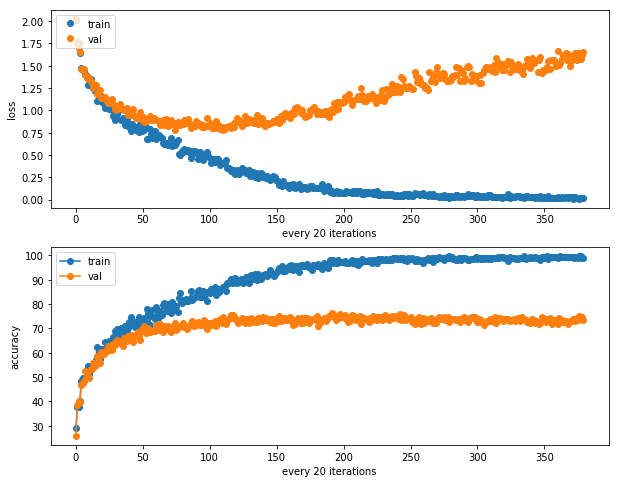

In [38]:
plt.subplot(2, 1, 1)
plt.plot(hist_3cv['train']['loss'], 'o')
plt.plot(hist_3cv['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_3cv['train']['accuracy'], '-o')
plt.plot(hist_3cv['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 1.2 Basic architecture ([conv-relu]x3 -> [affine]x1 -> [softmax])
Adding **2** more layers

In [39]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel3, h4, padding = pad4),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel4 * 32 * 32, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_4cv = train_my(model_base, optimizer, epochs = 10, display = True)
print()
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 14:14:23
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.3449
Loss: train = 1.5402814149856567, validate = 1.5218857526779175
Accuracy: train = 45.21, validate = 46.9

Iteration 200, loss = 1.4616
Loss: train = 1.3343005180358887, validate = 1.4151936769485474
Accuracy: train = 52.54, validate = 50.1

Iteration 300, loss = 1.2057
Loss: train = 1.24830162525177, validate = 1.2493178844451904
Accuracy: train = 55.57, validate = 55.1

Iteration 400, loss = 1.0671
Loss: train = 1.0768369436264038, validate = 1.1151560544967651
Accuracy: train = 60.84, validate = 60.7

Iteration 500, loss = 0.9545
Loss: train = 1.020324945449829, validate = 1.0340375900268555
Accuracy: train = 65.23, validate = 63.6

Iteration 600, loss = 0.8938
Loss: train = 0.9814034700393677, validate = 1.0030882358551025
Accuracy: train = 66.7, validate = 64.3

Iteration 700, loss = 0.9053
Loss: train = 0.8923582434654236, validate = 0.9844297170639038
Accuracy: train = 68.85, valid

Iteration 300, loss = 0.0179
Loss: train = 0.03629910200834274, validate = 1.3084064722061157
Accuracy: train = 99.12, validate = 76.8

Iteration 400, loss = 0.0742
Loss: train = 0.07029474526643753, validate = 1.3341928720474243
Accuracy: train = 97.75, validate = 75.8

Iteration 500, loss = 0.0790
Loss: train = 0.04716738313436508, validate = 1.3176428079605103
Accuracy: train = 98.05, validate = 76.2

Iteration 600, loss = 0.0874
Loss: train = 0.04004460573196411, validate = 1.2902997732162476
Accuracy: train = 98.54, validate = 76.6

Iteration 700, loss = 0.0410
Loss: train = 0.05656015872955322, validate = 1.2066067457199097
Accuracy: train = 98.14, validate = 74.9

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.1084
Loss: train = 0.04144427180290222, validate = 1.413033127784729
Accuracy: train = 98.44, validate = 76.6

Iteration 200, loss = 0.0371
Loss: train = 0.041296686977148056, validate = 1.3562135696411133
Accuracy: train = 98.63, validate = 75.

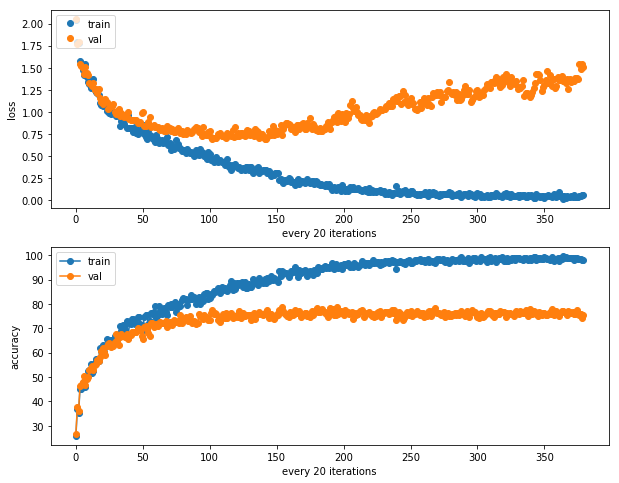

In [40]:
plt.subplot(2, 1, 1)
plt.plot(hist_4cv['train']['loss'], 'o')
plt.plot(hist_4cv['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_4cv['train']['accuracy'], '-o')
plt.plot(hist_4cv['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 2. Architecture 1: [conv-relu-pool]x3 -> [affine]x1 -> [softmax]

In [41]:
# same parameters for 3 CV + MaxPooling

# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
pad1, pad2, pad3 = (h1 - 1) //2, (h2 - 1) //2, (h3 - 1) //2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    Flatten(),
    nn.Linear(channel2 * 4 * 4, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_3cv_mp = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 15:12:41
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.7430
Loss: train = 1.5527030229568481, validate = 1.5929319858551025
Accuracy: train = 42.87, validate = 42.5

Iteration 200, loss = 1.4198
Loss: train = 1.4203994274139404, validate = 1.385798692703247
Accuracy: train = 47.36, validate = 52.0

Iteration 300, loss = 1.3780
Loss: train = 1.3163598775863647, validate = 1.3332947492599487
Accuracy: train = 50.59, validate = 51.4

Iteration 400, loss = 1.3102
Loss: train = 1.202486515045166, validate = 1.2477798461914062
Accuracy: train = 57.71, validate = 55.8

Iteration 500, loss = 1.2262
Loss: train = 1.045494556427002, validate = 1.1425775289535522
Accuracy: train = 64.26, validate = 59.9

Iteration 600, loss = 1.1545
Loss: train = 1.092726707458496, validate = 1.1535422801971436
Accuracy: train = 60.06, validate = 60.0

Iteration 700, loss = 0.7531
Loss: train = 1.1045926809310913, validate = 1.132294774055481
Accuracy: train = 62.89, valida

Iteration 300, loss = 0.0106
Loss: train = 0.06741347163915634, validate = 1.1761337518692017
Accuracy: train = 98.05, validate = 76.3

Iteration 400, loss = 0.0687
Loss: train = 0.0711454451084137, validate = 1.0855867862701416
Accuracy: train = 97.46, validate = 76.3

Iteration 500, loss = 0.1259
Loss: train = 0.0669453889131546, validate = 1.1699554920196533
Accuracy: train = 97.95, validate = 76.6

Iteration 600, loss = 0.1466
Loss: train = 0.05522274971008301, validate = 1.2085332870483398
Accuracy: train = 98.44, validate = 74.3

Iteration 700, loss = 0.2068
Loss: train = 0.07405877113342285, validate = 1.1474547386169434
Accuracy: train = 97.27, validate = 75.7

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0132
Loss: train = 0.033559881150722504, validate = 1.1747394800186157
Accuracy: train = 99.41, validate = 75.7

Iteration 200, loss = 0.0783
Loss: train = 0.03688378632068634, validate = 1.232453465461731
Accuracy: train = 98.83, validate = 76.8


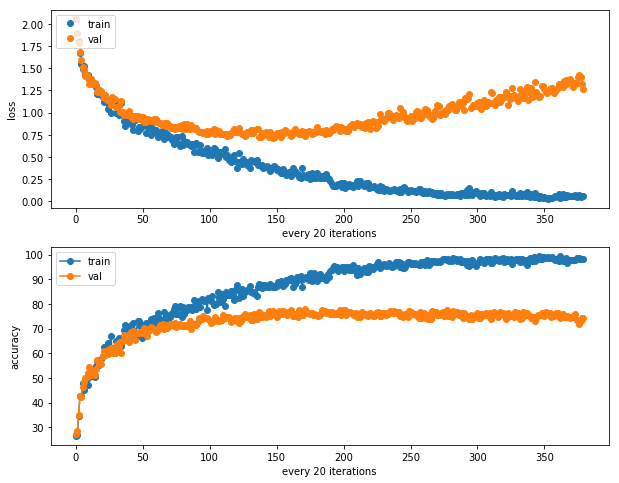

In [42]:
plt.subplot(2, 1, 1)
plt.plot(hist_3cv_mp['train']['loss'], 'o')
plt.plot(hist_3cv_mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_3cv_mp['train']['accuracy'], '-o')
plt.plot(hist_3cv_mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 2.1 Architecture 1: [conv-relu-pool]x4 -> [affine]x1 -> [softmax]
**4** layers in total

In [43]:
# same parameters for 4 CV + MaxPooling

# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_4cv_mp = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 15:19:01
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.7495
Loss: train = 1.6346436738967896, validate = 1.659079670906067
Accuracy: train = 42.29, validate = 43.2

Iteration 200, loss = 1.5924
Loss: train = 1.5863492488861084, validate = 1.4633722305297852
Accuracy: train = 42.68, validate = 47.6

Iteration 300, loss = 1.2825
Loss: train = 1.2301560640335083, validate = 1.2809818983078003
Accuracy: train = 57.03, validate = 56.4

Iteration 400, loss = 1.3231
Loss: train = 1.2451410293579102, validate = 1.2946968078613281
Accuracy: train = 55.96, validate = 54.8

Iteration 500, loss = 1.2394
Loss: train = 1.1936275959014893, validate = 1.2340977191925049
Accuracy: train = 58.3, validate = 57.7

Iteration 600, loss = 1.3385
Loss: train = 1.0705162286758423, validate = 1.1132482290267944
Accuracy: train = 62.21, validate = 61.1

Iteration 700, loss = 0.9445
Loss: train = 0.9631160497665405, validate = 1.0403648614883423
Accuracy: train = 65.62, val

Iteration 300, loss = 0.1362
Loss: train = 0.1020025759935379, validate = 1.096005916595459
Accuracy: train = 96.0, validate = 75.2

Iteration 400, loss = 0.1842
Loss: train = 0.07543717324733734, validate = 1.1485085487365723
Accuracy: train = 97.36, validate = 75.7

Iteration 500, loss = 0.0648
Loss: train = 0.10195142030715942, validate = 1.1318410634994507
Accuracy: train = 96.29, validate = 76.1

Iteration 600, loss = 0.1318
Loss: train = 0.0955255925655365, validate = 1.1314146518707275
Accuracy: train = 96.97, validate = 76.3

Iteration 700, loss = 0.1586
Loss: train = 0.07189665734767914, validate = 1.0771205425262451
Accuracy: train = 97.56, validate = 76.4

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0435
Loss: train = 0.06455891579389572, validate = 1.2450809478759766
Accuracy: train = 98.05, validate = 75.9

Iteration 200, loss = 0.0182
Loss: train = 0.06475856900215149, validate = 1.196712851524353
Accuracy: train = 97.66, validate = 76.2

It

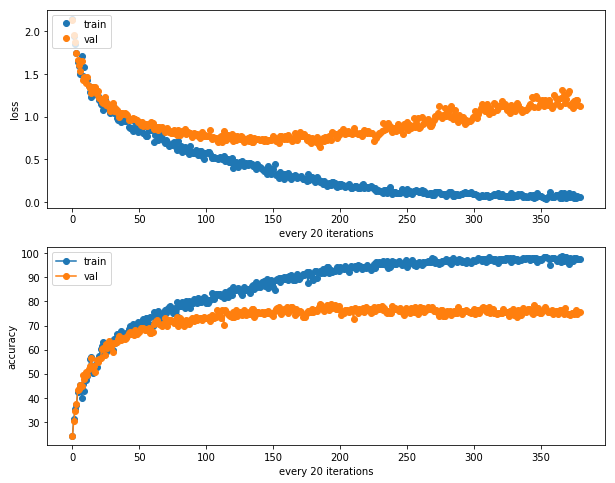

In [44]:
plt.subplot(2, 1, 1)
plt.plot(hist_4cv_mp['train']['loss'], 'o')
plt.plot(hist_4cv_mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_4cv_mp['train']['accuracy'], '-o')
plt.plot(hist_4cv_mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 3. Architecture 2: [conv-relu-conv-relu-pool]x2 -> [affine]x1 -> [softmax]

In [45]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 8 * 8, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = lr, momentum = 0.9, nesterov = True)
hist_4cv_2mp = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 15:25:37
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.7484
Loss: train = 1.5968888998031616, validate = 1.5571162700653076
Accuracy: train = 40.23, validate = 45.2

Iteration 200, loss = 1.5276
Loss: train = 1.3889483213424683, validate = 1.363878607749939
Accuracy: train = 49.71, validate = 51.1

Iteration 300, loss = 1.2003
Loss: train = 1.163662314414978, validate = 1.1486144065856934
Accuracy: train = 59.18, validate = 59.7

Iteration 400, loss = 1.2177
Loss: train = 1.125145673751831, validate = 1.0868968963623047
Accuracy: train = 60.25, validate = 63.0

Iteration 500, loss = 1.1478
Loss: train = 0.9875073432922363, validate = 1.037950038909912
Accuracy: train = 67.29, validate = 63.3

Iteration 600, loss = 0.9827
Loss: train = 0.8616594076156616, validate = 0.9122955203056335
Accuracy: train = 69.73, validate = 68.4

Iteration 700, loss = 0.9369
Loss: train = 0.833066999912262, validate = 0.833981454372406
Accuracy: train = 71.97, validat

Iteration 300, loss = 0.1364
Loss: train = 0.09305120259523392, validate = 1.1301244497299194
Accuracy: train = 96.09, validate = 77.6

Iteration 400, loss = 0.1974
Loss: train = 0.13153702020645142, validate = 1.0940687656402588
Accuracy: train = 95.7, validate = 78.6

Iteration 500, loss = 0.1955
Loss: train = 0.16137219965457916, validate = 1.0218112468719482
Accuracy: train = 94.24, validate = 78.0

Iteration 600, loss = 0.2967
Loss: train = 0.1010335236787796, validate = 1.0517295598983765
Accuracy: train = 96.09, validate = 77.5

Iteration 700, loss = 0.1316
Loss: train = 0.1113678589463234, validate = 0.9880568981170654
Accuracy: train = 96.68, validate = 78.3

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.2220
Loss: train = 0.08635067194700241, validate = 1.0157350301742554
Accuracy: train = 97.27, validate = 78.6

Iteration 200, loss = 0.0672
Loss: train = 0.09395717084407806, validate = 1.034641146659851
Accuracy: train = 96.97, validate = 79.4

I

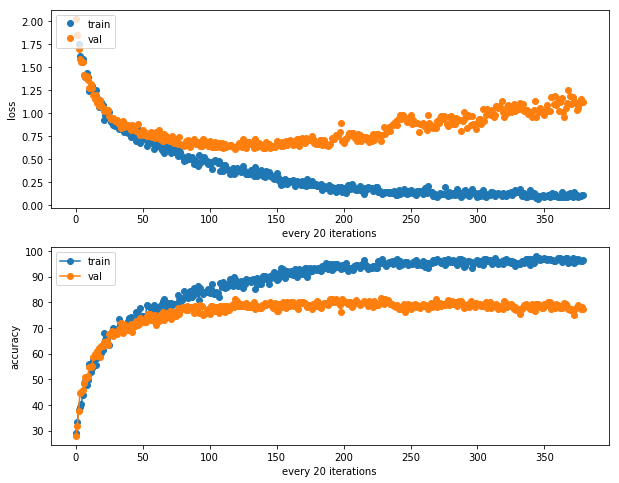

In [46]:
plt.subplot(2, 1, 1)
plt.plot(hist_4cv_2mp['train']['loss'], 'o')
plt.plot(hist_4cv_2mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_4cv_2mp['train']['accuracy'], '-o')
plt.plot(hist_4cv_2mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 3.1 Architecture 2: [conv-relu-conv-relu-pool]x4 -> [affine]x1 -> [softmax]

In [47]:
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_8cv_4mp = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 15:43:43
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.9043
Loss: train = 1.998257040977478, validate = 1.9903080463409424
Accuracy: train = 26.86, validate = 29.0

Iteration 200, loss = 1.6064
Loss: train = 1.7903696298599243, validate = 1.7260948419570923
Accuracy: train = 35.55, validate = 37.8

Iteration 300, loss = 1.5334
Loss: train = 1.6080394983291626, validate = 1.5753825902938843
Accuracy: train = 41.8, validate = 43.4

Iteration 400, loss = 1.3168
Loss: train = 1.4565699100494385, validate = 1.421980857849121
Accuracy: train = 47.07, validate = 47.8

Iteration 500, loss = 1.4503
Loss: train = 1.3668723106384277, validate = 1.4069328308105469
Accuracy: train = 50.1, validate = 47.5

Iteration 600, loss = 1.3111
Loss: train = 1.1884493827819824, validate = 1.213263750076294
Accuracy: train = 55.76, validate = 55.8

Iteration 700, loss = 1.0723
Loss: train = 1.1599749326705933, validate = 1.1750432252883911
Accuracy: train = 59.18, valida

Iteration 300, loss = 0.0998
Loss: train = 0.14906010031700134, validate = 0.6888606548309326
Accuracy: train = 95.21, validate = 81.4

Iteration 400, loss = 0.2026
Loss: train = 0.16901512444019318, validate = 0.6818563938140869
Accuracy: train = 94.43, validate = 81.0

Iteration 500, loss = 0.1657
Loss: train = 0.2649660110473633, validate = 0.848895251750946
Accuracy: train = 90.23, validate = 76.9

Iteration 600, loss = 0.2560
Loss: train = 0.123011015355587, validate = 0.6658578515052795
Accuracy: train = 95.41, validate = 81.9

Iteration 700, loss = 0.2018
Loss: train = 0.12016811221837997, validate = 0.6605652570724487
Accuracy: train = 96.29, validate = 82.4

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0793
Loss: train = 0.13795337080955505, validate = 0.6906792521476746
Accuracy: train = 95.31, validate = 83.8

Iteration 200, loss = 0.1458
Loss: train = 0.17959626019001007, validate = 0.8276141285896301
Accuracy: train = 93.95, validate = 79.4

I

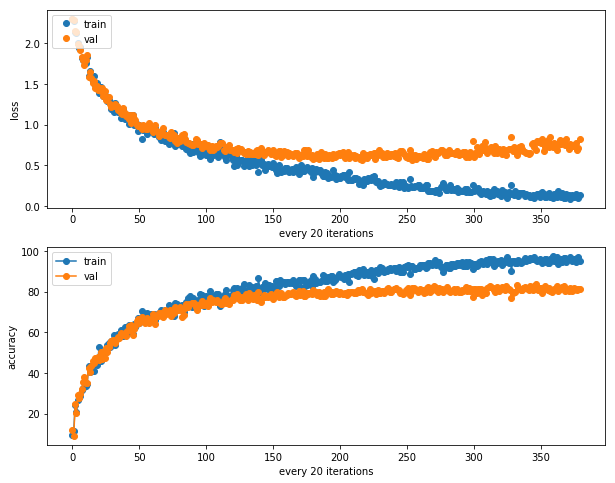

In [48]:
plt.subplot(2, 1, 1)
plt.plot(hist_8cv_4mp['train']['loss'], 'o')
plt.plot(hist_8cv_4mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_8cv_4mp['train']['accuracy'], '-o')
plt.plot(hist_8cv_4mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

In [78]:
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, weight_decay = learning_rate / 10, momentum = 0.9, nesterov = True)
hist_8cv_4mp_wd = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 23:49:28
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.0934
Loss: train = 2.0128390789031982, validate = 2.0087132453918457
Accuracy: train = 25.49, validate = 26.8

Iteration 200, loss = 1.7765
Loss: train = 1.728564977645874, validate = 1.6917312145233154
Accuracy: train = 34.18, validate = 38.8

Iteration 300, loss = 1.7001
Loss: train = 1.5532221794128418, validate = 1.5350799560546875
Accuracy: train = 42.19, validate = 44.9

Iteration 400, loss = 1.2612
Loss: train = 1.3874211311340332, validate = 1.4048317670822144
Accuracy: train = 50.49, validate = 49.2

Iteration 500, loss = 1.3254
Loss: train = 1.327784776687622, validate = 1.3001394271850586
Accuracy: train = 51.37, validate = 52.8

Iteration 600, loss = 1.3076
Loss: train = 1.265256643295288, validate = 1.221086025238037
Accuracy: train = 51.76, validate = 55.8

Iteration 700, loss = 1.0930
Loss: train = 1.1124857664108276, validate = 1.1654475927352905
Accuracy: train = 59.96, valid

Iteration 300, loss = 0.2409
Loss: train = 0.2052152454853058, validate = 0.6527677178382874
Accuracy: train = 92.97, validate = 80.7

Iteration 400, loss = 0.1339
Loss: train = 0.2156991958618164, validate = 0.6821077466011047
Accuracy: train = 92.48, validate = 80.4

Iteration 500, loss = 0.2014
Loss: train = 0.23702117800712585, validate = 0.7344682216644287
Accuracy: train = 91.99, validate = 79.4

Iteration 600, loss = 0.3613
Loss: train = 0.225955069065094, validate = 0.6393221616744995
Accuracy: train = 92.48, validate = 81.3

Iteration 700, loss = 0.1914
Loss: train = 0.23850670456886292, validate = 0.6653957962989807
Accuracy: train = 91.02, validate = 80.8

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0951
Loss: train = 0.15840184688568115, validate = 0.6202828884124756
Accuracy: train = 95.12, validate = 83.0

Iteration 200, loss = 0.2135
Loss: train = 0.17179237306118011, validate = 0.6595933437347412
Accuracy: train = 94.73, validate = 81.9

I

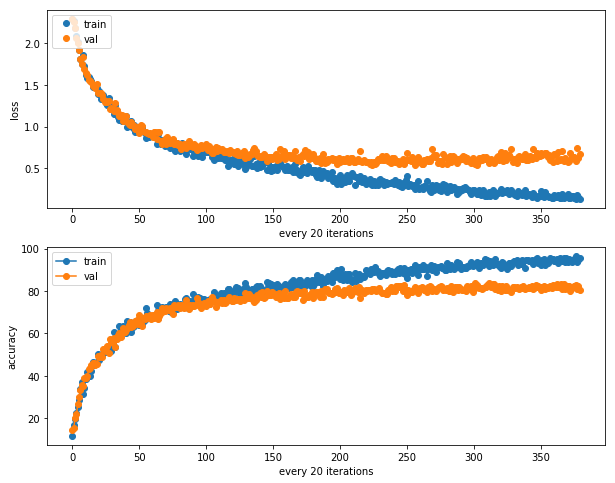

In [79]:
plt.subplot(2, 1, 1)
plt.plot(hist_8cv_4mp_wd['train']['loss'], 'o')
plt.plot(hist_8cv_4mp_wd['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_8cv_4mp_wd['train']['accuracy'], '-o')
plt.plot(hist_8cv_4mp_wd['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 3.2 Architecture 2: [conv-relu-conv-relu-pool]x5 -> [affine]x1 -> [softmax]

In [49]:
# 10 confolutions + 5 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 1 * 1, 10)
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_10cv_5mp = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 16:04:42
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.2991
Loss: train = 2.2973625659942627, validate = 2.298450469970703
Accuracy: train = 16.5, validate = 14.1

Iteration 200, loss = 2.1711
Loss: train = 2.0559210777282715, validate = 2.0654733180999756
Accuracy: train = 23.14, validate = 22.3

Iteration 300, loss = 1.8786
Loss: train = 1.8131859302520752, validate = 1.8212404251098633
Accuracy: train = 31.64, validate = 34.1

Iteration 400, loss = 1.7341
Loss: train = 1.651465892791748, validate = 1.6349905729293823
Accuracy: train = 35.94, validate = 39.0

Iteration 500, loss = 1.6176
Loss: train = 1.5823924541473389, validate = 1.582757830619812
Accuracy: train = 38.96, validate = 39.4

Iteration 600, loss = 1.4577
Loss: train = 1.4760069847106934, validate = 1.4564404487609863
Accuracy: train = 45.61, validate = 45.9

Iteration 700, loss = 1.4753
Loss: train = 1.434188961982727, validate = 1.4140408039093018
Accuracy: train = 45.31, valida

Iteration 300, loss = 0.1680
Loss: train = 0.2488270401954651, validate = 0.7192109227180481
Accuracy: train = 91.5, validate = 78.6

Iteration 400, loss = 0.5373
Loss: train = 0.21584858000278473, validate = 0.661166787147522
Accuracy: train = 92.48, validate = 81.4

Iteration 500, loss = 0.2744
Loss: train = 0.24743707478046417, validate = 0.6073375940322876
Accuracy: train = 91.89, validate = 81.5

Iteration 600, loss = 0.2392
Loss: train = 0.17253713309764862, validate = 0.6813099384307861
Accuracy: train = 94.82, validate = 79.1

Iteration 700, loss = 0.2862
Loss: train = 0.18218109011650085, validate = 0.6214119791984558
Accuracy: train = 93.75, validate = 81.1

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.1637
Loss: train = 0.15566733479499817, validate = 0.6836417317390442
Accuracy: train = 94.73, validate = 80.4

Iteration 200, loss = 0.1423
Loss: train = 0.14115944504737854, validate = 0.7259106636047363
Accuracy: train = 95.12, validate = 80.5



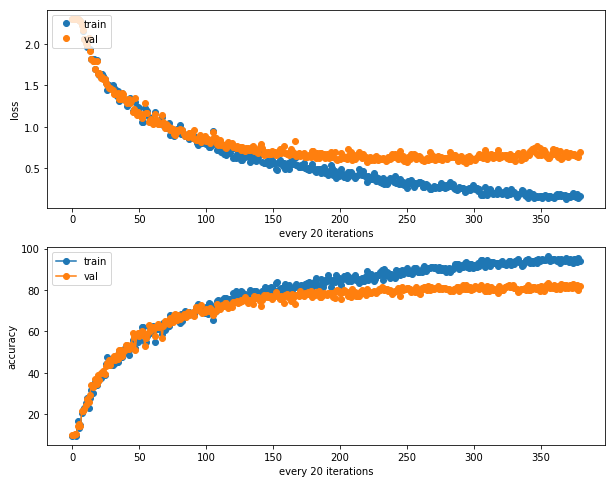

In [50]:
plt.subplot(2, 1, 1)
plt.plot(hist_10cv_5mp['train']['loss'], 'o')
plt.plot(hist_10cv_5mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_10cv_5mp['train']['accuracy'], '-o')
plt.plot(hist_10cv_5mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 3.2 Architecture 2: [conv-relu-conv-relu-pool]x4 -> [affine]x2 -> [softmax]
Adding **1** more fully connected layer

In [51]:
# 8 confolutions + 4 max pooling + 2fc
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model_base = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 4096),
    nn.ReLU(),
    
    nn.Linear(4096, 10),
    
)
# initialize weights
model_base.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model_base.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_8cv_4mp_2fc = train_my(model_base, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 16:38:57
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.2340
Loss: train = 2.216367483139038, validate = 2.2182631492614746
Accuracy: train = 19.63, validate = 19.1

Iteration 200, loss = 1.9751
Loss: train = 1.907034993171692, validate = 1.874974250793457
Accuracy: train = 29.3, validate = 29.7

Iteration 300, loss = 1.5941
Loss: train = 1.7175925970077515, validate = 1.6746509075164795
Accuracy: train = 31.74, validate = 36.8

Iteration 400, loss = 1.4236
Loss: train = 1.6887071132659912, validate = 1.5963146686553955
Accuracy: train = 37.89, validate = 41.3

Iteration 500, loss = 1.2688
Loss: train = 1.501516580581665, validate = 1.5211594104766846
Accuracy: train = 45.21, validate = 43.0

Iteration 600, loss = 1.5070
Loss: train = 1.4514425992965698, validate = 1.4257254600524902
Accuracy: train = 46.39, validate = 46.7

Iteration 700, loss = 1.0505
Loss: train = 1.2672255039215088, validate = 1.314987301826477
Accuracy: train = 53.61, validat

Iteration 300, loss = 0.0998
Loss: train = 0.19027210772037506, validate = 0.674732506275177
Accuracy: train = 93.55, validate = 80.9

Iteration 400, loss = 0.2013
Loss: train = 0.16306830942630768, validate = 0.6614418625831604
Accuracy: train = 94.43, validate = 81.2

Iteration 500, loss = 0.1218
Loss: train = 0.15325097739696503, validate = 0.7079629898071289
Accuracy: train = 94.14, validate = 80.7

Iteration 600, loss = 0.3849
Loss: train = 0.19144666194915771, validate = 0.6601397395133972
Accuracy: train = 93.46, validate = 80.9

Iteration 700, loss = 0.2598
Loss: train = 0.18244606256484985, validate = 0.7046900987625122
Accuracy: train = 93.16, validate = 79.6

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.2337
Loss: train = 0.14820881187915802, validate = 0.7117886543273926
Accuracy: train = 95.02, validate = 81.0

Iteration 200, loss = 0.1521
Loss: train = 0.16317202150821686, validate = 0.7168173789978027
Accuracy: train = 94.82, validate = 80.9

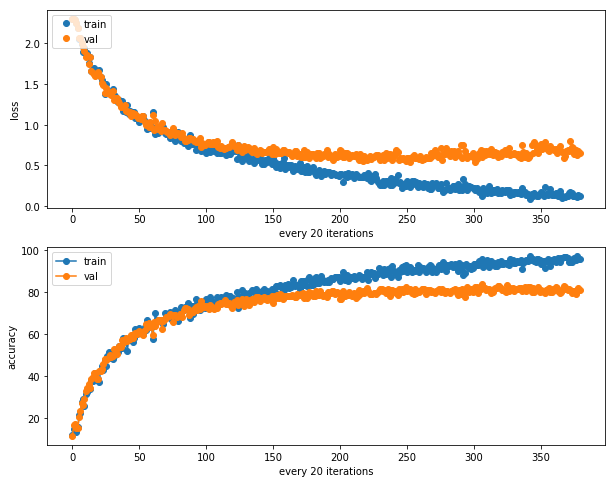

In [45]:
plt.subplot(2, 1, 1)
plt.plot(hist_8cv_4mp_2fc['train']['loss'], 'o')
plt.plot(hist_8cv_4mp_2fc['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_8cv_4mp_2fc['train']['accuracy'], '-o')
plt.plot(hist_8cv_4mp_2fc['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 4. Architecture: [conv-batchnorm-relu]x3 -> [affine]x1 -> [softmax]

In [64]:
# hyperparameters tuning

channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7

pad1, pad2, pad3 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2

print('Started at {}'.format(str(datetime.now().time())[:8]))
print('+' * 80)
print()
t = time()

for lr in [8e-4, 1e-3, 3e-3, 5e-3, 7e-3, 1e-2, 12e-3, 15e-3]:
    print('Learning rate = {}'.format(lr))
    # sequential model
    layer1 = nn.Sequential(
        nn.Conv2d(3, channel1, h1, padding = pad1),
        nn.BatchNorm2d(channel1),
        nn.ReLU(),
    )

    layer2 = nn.Sequential(
        nn.Conv2d(channel1, channel2, h2, padding = pad2),
        nn.BatchNorm2d(channel2),
        nn.ReLU(),
    )

    layer3 = nn.Sequential(
        nn.Conv2d(channel2, channel3, h3, padding = pad3),
        nn.BatchNorm2d(channel3),
        nn.ReLU(),
    )

    model = nn.Sequential(
        layer1,
        layer2,
        layer3,

        Flatten(),
        nn.Linear(channel3 * 32 * 32, 10)
    )

    # initialize weights
    model.apply(init_weights)
    # optimizer with Nesterov momentum
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, nesterov = True)
    hist = train_my(model, optimizer, epochs = 1, display = False)
    print()
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 19:20:34
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Learning rate = 0.0008
----------------
The best accuracy = 64.0 for epoch number 0 and iterations number 639

Learning rate = 0.001
----------------
The best accuracy = 65.2 for epoch number 0 and iterations number 739

Learning rate = 0.003
----------------
The best accuracy = 64.5 for epoch number 0 and iterations number 739

Learning rate = 0.005
----------------
The best accuracy = 62.9 for epoch number 0 and iterations number 719

Learning rate = 0.007
----------------
The best accuracy = 54.3 for epoch number 0 and iterations number 699

Learning rate = 0.01
----------------
The best accuracy = 40.8 for epoch number 0 and iterations number 739

Learning rate = 0.012
----------------
The best accuracy = 51.2 for epoch number 0 and iterations number 719

Learning rate = 0.015
----------------
The best accuracy = 46.0 for epoch number 0 and iterations number 659

++++++++++++++++++

In [65]:
# hyperparameters tuning

channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7

pad1, pad2, pad3 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2

print('Started at {}'.format(str(datetime.now().time())[:8]))
print('+' * 80)
print()
t = time()

for lr in [1e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 12e-4, 15e-4]:
    print('Learning rate = {}'.format(lr))
    # sequential model
    layer1 = nn.Sequential(
        nn.Conv2d(3, channel1, h1, padding = pad1),
        nn.BatchNorm2d(channel1),
        nn.ReLU(),
    )

    layer2 = nn.Sequential(
        nn.Conv2d(channel1, channel2, h2, padding = pad2),
        nn.BatchNorm2d(channel2),
        nn.ReLU(),
    )

    layer3 = nn.Sequential(
        nn.Conv2d(channel2, channel3, h3, padding = pad3),
        nn.BatchNorm2d(channel3),
        nn.ReLU(),
    )

    model = nn.Sequential(
        layer1,
        layer2,
        layer3,

        Flatten(),
        nn.Linear(channel3 * 32 * 32, 10)
    )

    # initialize weights
    model.apply(init_weights)
    # optimizer with Nesterov momentum
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, nesterov = True)
    hist = train_my(model, optimizer, epochs = 1, display = False)
    print()
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 19:58:51
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Learning rate = 1e-05
----------------
The best accuracy = 40.2 for epoch number 0 and iterations number 739

Learning rate = 0.0001
----------------
The best accuracy = 55.2 for epoch number 0 and iterations number 619

Learning rate = 0.0003
----------------
The best accuracy = 60.3 for epoch number 0 and iterations number 679

Learning rate = 0.0005
----------------
The best accuracy = 62.6 for epoch number 0 and iterations number 759

Learning rate = 0.0008
----------------
The best accuracy = 62.6 for epoch number 0 and iterations number 759

Learning rate = 0.001
----------------
The best accuracy = 66.6 for epoch number 0 and iterations number 699

Learning rate = 0.0012
----------------
The best accuracy = 65.6 for epoch number 0 and iterations number 699

Learning rate = 0.0015
----------------
The best accuracy = 65.1 for epoch number 0 and iterations number 699

++++++++++++

In [68]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7

pad1, pad2, pad3 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2
learning_rate = 0.001

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()

# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.BatchNorm2d(channel1),
    nn.ReLU(),
)

layer2 = nn.Sequential(
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.BatchNorm2d(channel2),
    nn.ReLU(),
)

layer3 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.BatchNorm2d(channel3),
    nn.ReLU(),

)
model = nn.Sequential(
    layer1,
    layer2,
    layer3,

    Flatten(),
    nn.Linear(channel3 * 32 * 32, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_bn_3cv = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))


Started at 21:36:18
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.3843
Loss: train = 1.429100751876831, validate = 1.4415979385375977
Accuracy: train = 50.0, validate = 49.4

Iteration 200, loss = 1.5799
Loss: train = 1.2661818265914917, validate = 1.4534074068069458
Accuracy: train = 55.76, validate = 50.6

Iteration 300, loss = 1.4133
Loss: train = 1.096294641494751, validate = 1.266225814819336
Accuracy: train = 62.7, validate = 57.2

Iteration 400, loss = 1.0112
Loss: train = 1.1465600728988647, validate = 1.2688597440719604
Accuracy: train = 58.89, validate = 56.7

Iteration 500, loss = 0.8255
Loss: train = 1.0622484683990479, validate = 1.234830617904663
Accuracy: train = 64.26, validate = 57.3

Iteration 600, loss = 0.8014
Loss: train = 0.8636227250099182, validate = 1.1160846948623657
Accuracy: train = 70.02, validate = 61.0

Iteration 700, loss = 1.1976
Loss: train = 0.8897918462753296, validate = 1.0332674980163574
Accuracy: train = 67.38, validat

Iteration 300, loss = 0.0739
Loss: train = 0.09272167831659317, validate = 0.8452719449996948
Accuracy: train = 98.44, validate = 74.5

Iteration 400, loss = 0.0970
Loss: train = 0.09407877177000046, validate = 0.879097580909729
Accuracy: train = 98.44, validate = 73.5

Iteration 500, loss = 0.1252
Loss: train = 0.07729656994342804, validate = 0.8538550734519958
Accuracy: train = 99.02, validate = 74.4

Iteration 600, loss = 0.1224
Loss: train = 0.06859555840492249, validate = 0.8468406200408936
Accuracy: train = 99.41, validate = 74.9

Iteration 700, loss = 0.1357
Loss: train = 0.0809377133846283, validate = 0.8576529622077942
Accuracy: train = 98.93, validate = 73.1

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.0341
Loss: train = 0.07051119208335876, validate = 0.8260921239852905
Accuracy: train = 99.41, validate = 74.6

Iteration 200, loss = 0.0527
Loss: train = 0.05363299697637558, validate = 0.8771717548370361
Accuracy: train = 99.71, validate = 74.1


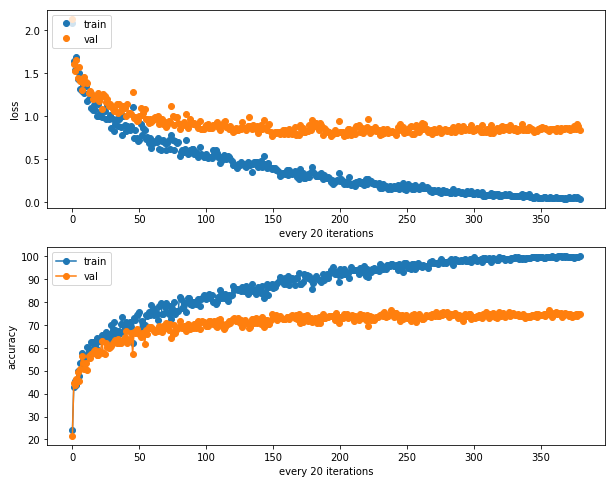

In [69]:
plt.subplot(2, 1, 1)
plt.plot(hist_bn_3cv['train']['loss'], 'o')
plt.plot(hist_bn_3cv['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_bn_3cv['train']['accuracy'], '-o')
plt.plot(hist_bn_3cv['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

Comparison with BN and without.

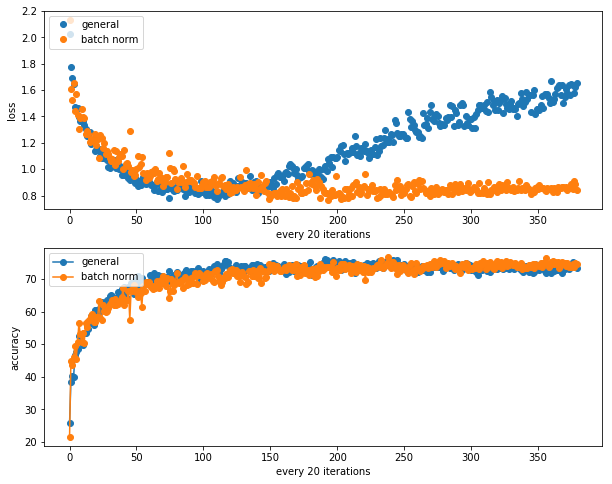

In [70]:
plt.subplot(2, 1, 1)
plt.plot(hist_3cv['validate']['loss'], 'o')
plt.plot(hist_bn_3cv['validate']['loss'], 'o')
plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_3cv['validate']['accuracy'], '-o')
plt.plot(hist_bn_3cv['validate']['accuracy'], '-o')

plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 4.1. Architecture: [conv-batchnorm-relu-maxpool]x3 -> [affine]x1 -> [softmax]

In [71]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7

pad1, pad2, pad3 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2
learning_rate = 0.001

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()

# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.BatchNorm2d(channel1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

layer2 = nn.Sequential(
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.BatchNorm2d(channel2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

layer3 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.BatchNorm2d(channel3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),

)
model = nn.Sequential(
    layer1,
    layer2,
    layer3,

    Flatten(),
    nn.Linear(channel3 * 4 * 4, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_bn_3cv_mp = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))


Started at 22:22:30
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.4871
Loss: train = 1.5074272155761719, validate = 1.5420399904251099
Accuracy: train = 49.32, validate = 46.4

Iteration 200, loss = 1.2315
Loss: train = 1.3496432304382324, validate = 1.3861582279205322
Accuracy: train = 52.73, validate = 52.5

Iteration 300, loss = 1.4532
Loss: train = 1.1928173303604126, validate = 1.2559571266174316
Accuracy: train = 57.91, validate = 57.1

Iteration 400, loss = 1.1847
Loss: train = 1.1731523275375366, validate = 1.213701605796814
Accuracy: train = 60.55, validate = 57.9

Iteration 500, loss = 1.1627
Loss: train = 1.135738730430603, validate = 1.1965935230255127
Accuracy: train = 60.16, validate = 58.8

Iteration 600, loss = 0.9843
Loss: train = 1.0610069036483765, validate = 1.1264814138412476
Accuracy: train = 64.75, validate = 61.5

Iteration 700, loss = 1.1519
Loss: train = 1.0280555486679077, validate = 1.0969756841659546
Accuracy: train = 64.16, val

Iteration 300, loss = 0.3532
Loss: train = 0.3647691607475281, validate = 0.7867386341094971
Accuracy: train = 90.23, validate = 73.6

Iteration 400, loss = 0.1948
Loss: train = 0.37096545100212097, validate = 0.7827304005622864
Accuracy: train = 88.48, validate = 72.4

Iteration 500, loss = 0.5387
Loss: train = 0.32794585824012756, validate = 0.7469651103019714
Accuracy: train = 90.72, validate = 74.6

Iteration 600, loss = 0.3618
Loss: train = 0.31713375449180603, validate = 0.783066987991333
Accuracy: train = 89.94, validate = 72.5

Iteration 700, loss = 0.5957
Loss: train = 0.32117801904678345, validate = 0.7728301286697388
Accuracy: train = 91.6, validate = 74.0

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.3218
Loss: train = 0.3228367269039154, validate = 0.7566416263580322
Accuracy: train = 91.7, validate = 74.4

Iteration 200, loss = 0.3051
Loss: train = 0.32824385166168213, validate = 0.7491172552108765
Accuracy: train = 90.53, validate = 75.3

It

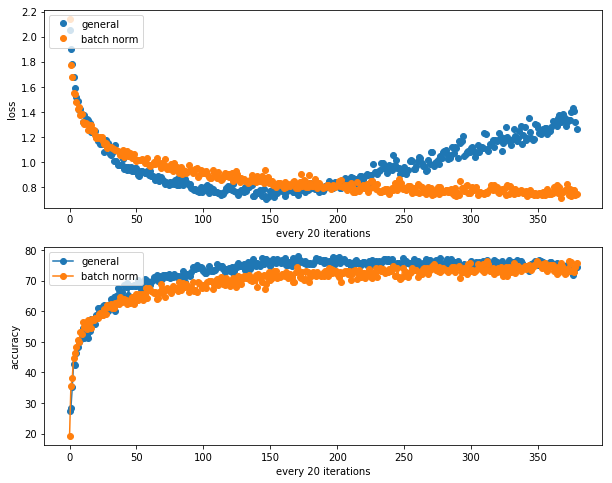

In [72]:
plt.subplot(2, 1, 1)
plt.plot(hist_3cv_mp['validate']['loss'], 'o')
plt.plot(hist_bn_3cv_mp['validate']['loss'], 'o')
plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_3cv_mp['validate']['accuracy'], '-o')
plt.plot(hist_bn_3cv_mp['validate']['accuracy'], '-o')

plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 4.2. Architecture: [conv-batchnorm-relu-conv-batchnorm-relu-maxpool]x4 -> [affine]x1 -> [softmax]

In [76]:
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5

pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.001

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()

# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.BatchNorm2d(channel1),
    nn.ReLU(),
    
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.BatchNorm2d(channel2),
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

layer2 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.BatchNorm2d(channel3),
    nn.ReLU(),
    
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.BatchNorm2d(channel4),
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

layer3 = nn.Sequential(
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.BatchNorm2d(channel1),
    nn.ReLU(),
    
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.BatchNorm2d(channel2),
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

layer4 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.BatchNorm2d(channel3),
    nn.ReLU(),
    
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.BatchNorm2d(channel4),
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

model = nn.Sequential(
    layer1,
    layer2,
    layer3,
    layer4,

    Flatten(),
    nn.Linear(channel3 * 2 * 2, 4096),
    nn.ReLU(),
    
    nn.Linear(4096, 10),
)

# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
# optimizer = optim.Adagrad(model.parameters(), lr = learning_rate)
hist_bn_8cv_4mp_2fc = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))


Started at 22:55:43
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 1.6123
Loss: train = 1.6768757104873657, validate = 1.6540805101394653
Accuracy: train = 37.4, validate = 37.8

Iteration 200, loss = 1.3333
Loss: train = 1.4821341037750244, validate = 1.4101006984710693
Accuracy: train = 45.21, validate = 51.4

Iteration 300, loss = 1.3899
Loss: train = 1.3058640956878662, validate = 1.299505352973938
Accuracy: train = 53.42, validate = 53.6

Iteration 400, loss = 1.5087
Loss: train = 1.2604750394821167, validate = 1.2196894884109497
Accuracy: train = 54.39, validate = 57.1

Iteration 500, loss = 1.0402
Loss: train = 1.141876459121704, validate = 1.1062582731246948
Accuracy: train = 57.62, validate = 59.9

Iteration 600, loss = 0.9972
Loss: train = 1.2321131229400635, validate = 1.2218672037124634
Accuracy: train = 56.54, validate = 56.7

Iteration 700, loss = 1.0862
Loss: train = 1.0496532917022705, validate = 1.0198386907577515
Accuracy: train = 62.11, vali

Iteration 300, loss = 0.1982
Loss: train = 0.19324493408203125, validate = 0.7214865684509277
Accuracy: train = 93.36, validate = 78.6

Iteration 400, loss = 0.1431
Loss: train = 0.2703518867492676, validate = 0.7886991500854492
Accuracy: train = 90.14, validate = 78.1

Iteration 500, loss = 0.3339
Loss: train = 0.18186689913272858, validate = 0.6950547099113464
Accuracy: train = 94.14, validate = 79.5

Iteration 600, loss = 0.2684
Loss: train = 0.23466509580612183, validate = 0.7860803604125977
Accuracy: train = 91.5, validate = 77.8

Iteration 700, loss = 0.2651
Loss: train = 0.22100664675235748, validate = 0.7851178050041199
Accuracy: train = 92.19, validate = 76.6

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.1682
Loss: train = 0.15664005279541016, validate = 0.7211196422576904
Accuracy: train = 94.63, validate = 78.0

Iteration 200, loss = 0.1507
Loss: train = 0.20405195653438568, validate = 0.7784937024116516
Accuracy: train = 92.29, validate = 78.3


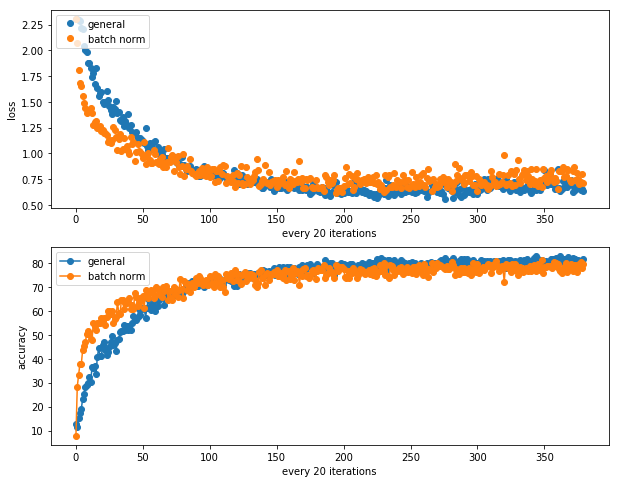

In [77]:
plt.subplot(2, 1, 1)
plt.plot(hist_8cv_4mp_2fc['validate']['loss'], 'o')
plt.plot(hist_bn_8cv_4mp_2fc['validate']['loss'], 'o')
plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_8cv_4mp_2fc['validate']['accuracy'], '-o')
plt.plot(hist_bn_8cv_4mp_2fc['validate']['accuracy'], '-o')

plt.legend(['general', 'batch norm'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

### 5. Regularization

In [80]:
# Dropout with 0.7 probability
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer2 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer3 = nn.Sequential(
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer4 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(0.7),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

model = nn.Sequential(
    layer1,
    layer2,
    layer3,
    layer4,
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_do_8cv_4mp = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 00:41:31
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.2927
Loss: train = 2.304326057434082, validate = 2.3028223514556885
Accuracy: train = 9.47, validate = 11.2

Iteration 200, loss = 2.2900
Loss: train = 2.305365562438965, validate = 2.3039801120758057
Accuracy: train = 9.18, validate = 10.2

Iteration 300, loss = 2.2729
Loss: train = 2.302265167236328, validate = 2.3094143867492676
Accuracy: train = 9.86, validate = 7.8

Iteration 400, loss = 2.2986
Loss: train = 2.3072848320007324, validate = 2.3132901191711426
Accuracy: train = 8.79, validate = 10.2

Iteration 500, loss = 2.2715
Loss: train = 2.3118033409118652, validate = 2.316549777984619
Accuracy: train = 10.25, validate = 10.2

Iteration 600, loss = 2.2524
Loss: train = 2.310372829437256, validate = 2.3174872398376465
Accuracy: train = 12.11, validate = 10.2

Iteration 700, loss = 2.1963
Loss: train = 2.3166351318359375, validate = 2.3267087936401367
Accuracy: train = 9.57, validate = 1

Iteration 500, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 9.57, validate = 8.7

Iteration 600, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 10.55, validate = 8.7

Iteration 700, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 10.25, validate = 8.7

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 10.74, validate = 8.7

Iteration 200, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 9.47, validate = 8.7

Iteration 300, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 10.25, validate = 8.7

Iteration 400, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 9.38, validate = 8.7

Iteration 500, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 10.64, validate = 8.7

Iteration 600, loss = nan
Loss: train = nan, validate = nan
Accuracy: train = 9.28, validate = 8.7

Iteration 700, loss = nan
Loss: train = nan,

In [82]:
# Dropout with 0.1 probability
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer2 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer3 = nn.Sequential(
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer4 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(0.1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

model = nn.Sequential(
    layer1,
    layer2,
    layer3,
    layer4,
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_do01_8cv_4mp = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 01:03:42
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.2020
Loss: train = 2.1216933727264404, validate = 2.1548807621002197
Accuracy: train = 21.29, validate = 20.1

Iteration 200, loss = 2.0205
Loss: train = 1.763594150543213, validate = 1.8109092712402344
Accuracy: train = 35.74, validate = 32.4

Iteration 300, loss = 1.7385
Loss: train = 1.6827309131622314, validate = 1.673590898513794
Accuracy: train = 36.33, validate = 36.3

Iteration 400, loss = 1.7428
Loss: train = 1.5810251235961914, validate = 1.5378388166427612
Accuracy: train = 40.14, validate = 43.1

Iteration 500, loss = 1.5085
Loss: train = 1.5430057048797607, validate = 1.4987555742263794
Accuracy: train = 41.6, validate = 45.8

Iteration 600, loss = 1.3267
Loss: train = 1.4142756462097168, validate = 1.4127262830734253
Accuracy: train = 47.95, validate = 47.0

Iteration 700, loss = 1.3191
Loss: train = 1.4137777090072632, validate = 1.3741809129714966
Accuracy: train = 47.27, vali

Iteration 300, loss = 0.4816
Loss: train = 0.32368773221969604, validate = 0.5478144288063049
Accuracy: train = 89.16, validate = 81.5

Iteration 400, loss = 0.3884
Loss: train = 0.2689703404903412, validate = 0.5560541152954102
Accuracy: train = 91.21, validate = 81.8

Iteration 500, loss = 0.4814
Loss: train = 0.3364796042442322, validate = 0.5768658518791199
Accuracy: train = 88.18, validate = 80.9

Iteration 600, loss = 0.2101
Loss: train = 0.3023375868797302, validate = 0.5654760003089905
Accuracy: train = 89.94, validate = 81.6

Iteration 700, loss = 0.6530
Loss: train = 0.33532553911209106, validate = 0.5492812991142273
Accuracy: train = 89.55, validate = 82.0

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.4105
Loss: train = 0.2974810004234314, validate = 0.5675919651985168
Accuracy: train = 90.72, validate = 82.2

Iteration 200, loss = 0.4125
Loss: train = 0.29871484637260437, validate = 0.564460813999176
Accuracy: train = 89.84, validate = 81.5

It

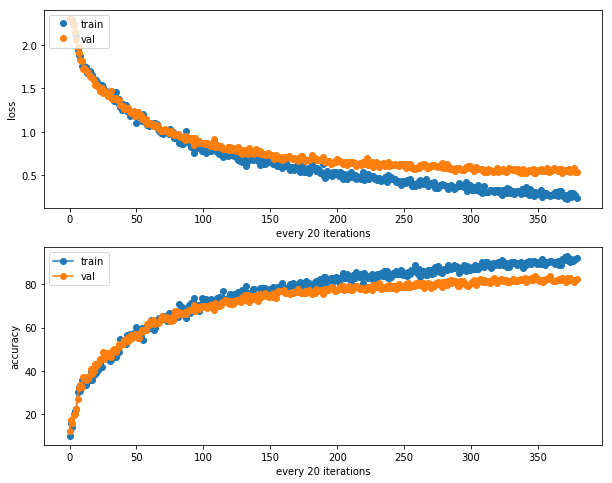

In [89]:
plt.subplot(2, 1, 1)
plt.plot(hist_do01_8cv_4mp['train']['loss'], 'o')
plt.plot(hist_do01_8cv_4mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_do01_8cv_4mp['train']['accuracy'], '-o')
plt.plot(hist_do01_8cv_4mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

In [86]:
# Dropout with 0.2 probability
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007
do = 0.2

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer2 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer3 = nn.Sequential(
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer4 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

model = nn.Sequential(
    layer1,
    layer2,
    layer3,
    layer4,
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_do02_8cv_4mp = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 09:13:29
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.2687
Loss: train = 2.250497341156006, validate = 2.239952564239502
Accuracy: train = 18.55, validate = 18.7

Iteration 200, loss = 2.0291
Loss: train = 1.9087225198745728, validate = 1.9240611791610718
Accuracy: train = 28.71, validate = 28.1

Iteration 300, loss = 1.8811
Loss: train = 1.8043036460876465, validate = 1.8019770383834839
Accuracy: train = 31.84, validate = 31.4

Iteration 400, loss = 1.6716
Loss: train = 1.676916241645813, validate = 1.686856985092163
Accuracy: train = 38.09, validate = 36.0

Iteration 500, loss = 1.6741
Loss: train = 1.617680311203003, validate = 1.5979911088943481
Accuracy: train = 39.06, validate = 40.0

Iteration 600, loss = 1.4731
Loss: train = 1.6065707206726074, validate = 1.5501952171325684
Accuracy: train = 37.4, validate = 42.5

Iteration 700, loss = 1.5818
Loss: train = 1.5235565900802612, validate = 1.5148475170135498
Accuracy: train = 42.29, validat

Iteration 300, loss = 0.6399
Loss: train = 0.5039042830467224, validate = 0.6317028999328613
Accuracy: train = 81.64, validate = 78.3

Iteration 400, loss = 0.4176
Loss: train = 0.49582669138908386, validate = 0.6764549016952515
Accuracy: train = 81.74, validate = 77.1

Iteration 500, loss = 0.7691
Loss: train = 0.49801868200302124, validate = 0.6397488713264465
Accuracy: train = 83.69, validate = 78.3

Iteration 600, loss = 0.7465
Loss: train = 0.4984493851661682, validate = 0.646681547164917
Accuracy: train = 83.01, validate = 77.3

Iteration 700, loss = 0.6376
Loss: train = 0.5210375189781189, validate = 0.6560493111610413
Accuracy: train = 82.42, validate = 77.3

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.6272
Loss: train = 0.46814826130867004, validate = 0.6397789716720581
Accuracy: train = 84.38, validate = 77.2

Iteration 200, loss = 0.6319
Loss: train = 0.5162564516067505, validate = 0.6425718069076538
Accuracy: train = 81.45, validate = 77.7

It

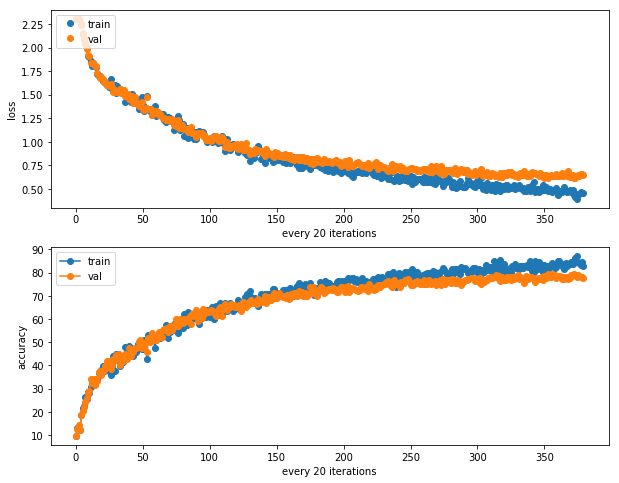

In [90]:
plt.subplot(2, 1, 1)
plt.plot(hist_do02_8cv_4mp['train']['loss'], 'o')
plt.plot(hist_do02_8cv_4mp['validate']['loss'], 'o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(hist_do02_8cv_4mp['train']['accuracy'], '-o')
plt.plot(hist_do02_8cv_4mp['validate']['accuracy'], '-o')

plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('every 20 iterations')
plt.ylabel('accuracy')
plt.show()

In [91]:
# Dropout with 0.2 probability
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007
do = 0.1

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
layer1 = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer2 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer3 = nn.Sequential(
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)
layer4 = nn.Sequential(
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.Dropout2d(do),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
)

model = nn.Sequential(
    layer1,
    layer2,
    layer3,
    layer4,
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = 0.001, momentum = 0.9, nesterov = True)
hist_do01_8cv_4mp_wd = train_my(model, optimizer, epochs = 10, display = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 09:39:34
----------------
--- Epoch  0 ---
----------------
Iteration 100, loss = 2.1173
Loss: train = 2.1290535926818848, validate = 2.1220200061798096
Accuracy: train = 23.34, validate = 24.2

Iteration 200, loss = 2.0814
Loss: train = 1.8433887958526611, validate = 1.8795808553695679
Accuracy: train = 30.57, validate = 29.8

Iteration 300, loss = 1.8261
Loss: train = 1.7619404792785645, validate = 1.7400197982788086
Accuracy: train = 36.62, validate = 37.4

Iteration 400, loss = 1.6573
Loss: train = 1.680472731590271, validate = 1.6646270751953125
Accuracy: train = 36.04, validate = 37.3

Iteration 500, loss = 1.5795
Loss: train = 1.5825378894805908, validate = 1.5331614017486572
Accuracy: train = 42.29, validate = 42.4

Iteration 600, loss = 1.4849
Loss: train = 1.483780860900879, validate = 1.4546672105789185
Accuracy: train = 45.41, validate = 46.7

Iteration 700, loss = 1.5133
Loss: train = 1.4125280380249023, validate = 1.3897888660430908
Accuracy: train = 50.0, vali

Iteration 300, loss = 0.4844
Loss: train = 0.40292125940322876, validate = 0.584284782409668
Accuracy: train = 86.91, validate = 79.2

Iteration 400, loss = 0.5191
Loss: train = 0.3800281584262848, validate = 0.6321580410003662
Accuracy: train = 86.52, validate = 79.0

Iteration 500, loss = 0.3291
Loss: train = 0.37939560413360596, validate = 0.5705326795578003
Accuracy: train = 86.23, validate = 81.3

Iteration 600, loss = 0.6942
Loss: train = 0.3810082674026489, validate = 0.5604510307312012
Accuracy: train = 87.11, validate = 81.5

Iteration 700, loss = 0.5290
Loss: train = 0.3526413142681122, validate = 0.5745269656181335
Accuracy: train = 87.79, validate = 81.3

----------------
--- Epoch  9 ---
----------------
Iteration 100, loss = 0.4562
Loss: train = 0.34337201714515686, validate = 0.5641571283340454
Accuracy: train = 89.16, validate = 81.1

Iteration 200, loss = 0.4440
Loss: train = 0.3220430612564087, validate = 0.576431155204773
Accuracy: train = 89.45, validate = 80.0

Ite

In [95]:
# 8 confolutions + 4 max pooling
# input: 64x3x32x32
channel1, h1 = 32, 3
channel2, h2 = 128, 3
channel3, h3 = 128, 7
channel4, h4 = 128, 5
pad1, pad2, pad3, pad4 = (h1 - 1) // 2, (h2 - 1) // 2, (h3 - 1) // 2, (h4 - 1) // 2
learning_rate = 0.007

print('Started at {}'.format(str(datetime.now().time())[:8]))
t = time()
# sequential model
model = nn.Sequential(
    nn.Conv2d(3, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel4, channel1, h1, padding = pad1),
    nn.ReLU(),
    nn.Conv2d(channel1, channel2, h2, padding = pad2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(channel2, channel3, h3, padding = pad3),
    nn.ReLU(),
    nn.Conv2d(channel3, channel4, h4, padding = pad4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    Flatten(),
    nn.Linear(channel2 * 2 * 2, 10)
)
# initialize weights
model.apply(init_weights)
# optimizer with Nesterov momentum
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, nesterov = True)
hist_8cv_4mp_l2 = train_my(model, optimizer, epochs = 10, display = True, l2_reg = True)
print('+' * 80)
print('Finished at {}'.format(str(datetime.now().time())[:8]))
print('{} min. {} sec.'.format(round(time() - t) // 60, round(time() - t) % 60))

Started at 10:17:37
----------------
--- Epoch  0 ---
----------------


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Describe what you did

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [ ]:
best_model = model
check_accuracy_part34(loader_test, best_model)